In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
nlp = spacy.load("en_core_web_sm")

In /home/fatma/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/fatma/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/fatma/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/fatma/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/fatma/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

In [3]:
twitter_rac_test_df = pd.read_csv("../../../Data/Twitter_sexism/Twitter_sex_data_test.csv")

In [4]:
twitter_rac_test_df.columns

Index(['index', 'id', 'Text', 'Annotation', 'oh_label', 'Text_clean_for_BERT',
       'Text_clean', 'LSTM_prediction', 'BiLSTM_prediction',
       'BERT_prediction_no_stem', 'NFT_BERT_prediction',
       'BERT_NFT_Twitter_sexism_clean_text_64'],
      dtype='object')

In [5]:
data_test_correct_Bert_prediction = twitter_rac_test_df[twitter_rac_test_df.BERT_prediction_no_stem == twitter_rac_test_df.oh_label]

data_test_wrong_Bert_prediction = twitter_rac_test_df[twitter_rac_test_df.BERT_prediction_no_stem != twitter_rac_test_df.oh_label]

In [6]:
len(data_test_correct_Bert_prediction), len(data_test_wrong_Bert_prediction)

(3949, 473)

In [7]:
TP = data_test_correct_Bert_prediction[data_test_correct_Bert_prediction["BERT_prediction_no_stem"] == 1]
TN = data_test_correct_Bert_prediction[data_test_correct_Bert_prediction["BERT_prediction_no_stem"] == 0]

In [8]:
FP = data_test_wrong_Bert_prediction[data_test_wrong_Bert_prediction["BERT_prediction_no_stem"] == 1]
FN = data_test_wrong_Bert_prediction[data_test_wrong_Bert_prediction["BERT_prediction_no_stem"] == 0]

In [9]:
len(TP),len(TN),len(FP), len(FN)

(777, 3172, 236, 237)

## get the linguistic features in the dataset

In [10]:
def return_pos_features(doc):
  text = []
  lemma = []
  pos = []
  tag = []
  dep = []
  shape = []
  is_alpha = []
  is_stop = []
  for token in doc:
      text.append(token.text)
      lemma.append(token.lemma_)
      pos.append(token.pos_)
      tag.append(token.tag_)
      dep.append(token.dep_)
      shape.append(token.shape_)
      is_alpha.append(token.is_alpha)
      is_stop.append(token.is_stop)
  featurs_df = pd.DataFrame.from_dict({"text":text,"lemma":lemma,"pos":pos,"tag":tag,"dep":dep,"shape":shape,"is_alpha":is_alpha,"is_stop":is_stop})
  return featurs_df

def return_NERT_featurs(docs):
  text = []
  ner_label = []
  for ent in docs.ents:
      text.append(ent.text)
      ner_label.append(ent.label_)
  featurs_df = pd.DataFrame.from_dict({"text":text,"ner_label":ner_label})
  return featurs_df

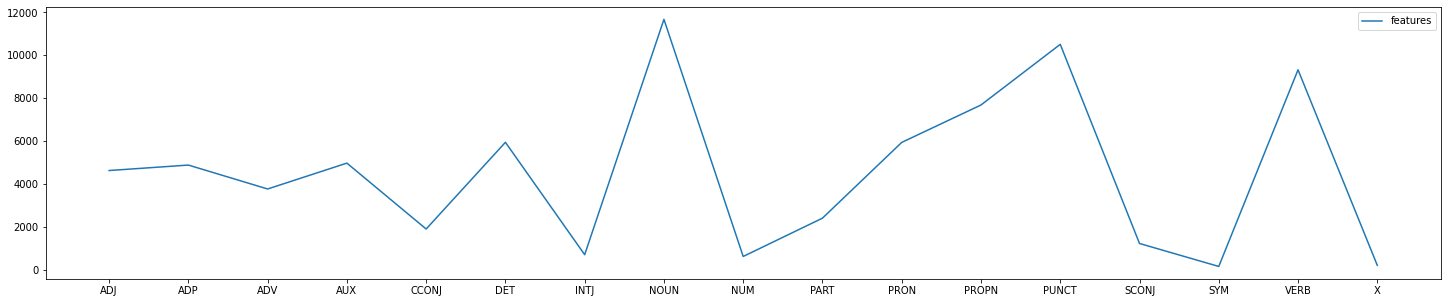

In [11]:
#data_correct_prediction_docs = "/n".join(data_test_correct_Bert_prediction["Text_clean_for_BERT"])
#data_wrong_prediction_docs = "/n".join(data_test_wrong_Bert_prediction["Text_clean_for_BERT"])
data_docs = " ".join(twitter_rac_test_df["Text_clean_for_BERT"])
#data_correct_prediction_features = nlp(data_correct_prediction_docs, disable = ['ner', 'parser'])
#data_wrong_prediction_features = nlp(data_wrong_prediction_docs, disable = ['ner', 'parser'])
data_docs_features = nlp(data_docs, disable = ['ner', 'parser'])
#data_correct_prediction_features_df = return_pos_features(data_correct_prediction_features) 
#data_wrong_prediction_features_df = return_pos_features(data_wrong_prediction_features) 
data_docs_features_df = return_pos_features(data_docs_features) 

import matplotlib.pyplot as plt
plt.subplots(figsize=(25, 5))
#plt.plot(data_correct_prediction_features_df.groupby(data_correct_prediction_features_df["pos"]).pos.count(), label="correct_prediction_features")
#plt.plot(data_wrong_prediction_features_df.groupby(data_wrong_prediction_features_df["pos"]).pos.count(),label="wrong_prediction_features")
plt.plot(data_docs_features_df.groupby(data_docs_features_df["pos"]).pos.count(),label="features")

plt.legend()

## get the attribution scores of all the unique words from BERT FT on Twitter racism DS
## test dataset

In [12]:
attribution_scores = pd.read_csv("attribution_Scores/Fine-tuned_BERT/Twitter_sexism_1000_data_fine_tuned_bert_attribution_scores.csv")

In [13]:
len(attribution_scores)

20574

In [14]:
attribution_scores.head()

,words,attribution,abs_attribution
0,dare,-6.441997e-07,6.441997e-07
1,i,2.256630e-06,2.256630e-06
2,say,3.477848e-06,3.477848e-06
3,it,1.789305e-06,1.789305e-06
4,?,-5.469990e-07,5.469990e-07


In [15]:
attribution_scores["abs_attribution"] = [np.absolute(i) for i in attribution_scores.attribution]
word_attribution_grp = attribution_scores.groupby(attribution_scores["words"])

In [16]:
import numpy as np

unique_words = []
avg_attribution = []
avg_abs_attribution = []
no_occurances = []
for name,grp in word_attribution_grp:
    unique_words.append(name)
    avg_attribution.append(np.mean(grp["attribution"]))
    avg_abs_attribution.append(np.mean(grp["abs_attribution"]))
    no_occurances.append(len(grp["attribution"]))

In [17]:
word_attribution_unique = {}
word_attribution_unique["unique_words"] = unique_words
word_attribution_unique["attribution"] = avg_attribution
word_attribution_unique["abs_attribution"] = avg_abs_attribution
word_attribution_unique["No_occurences"] = no_occurances

In [18]:
word_attribution_unique_df = pd.DataFrame.from_dict(word_attribution_unique)
len(word_attribution_unique_df)

3878

<AxesSubplot:>

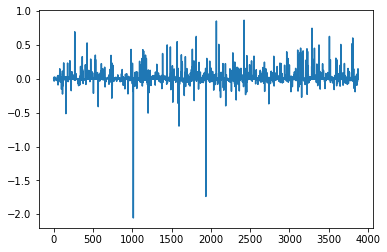

In [19]:
word_attribution_unique_df["attribution"].plot()

<AxesSubplot:>

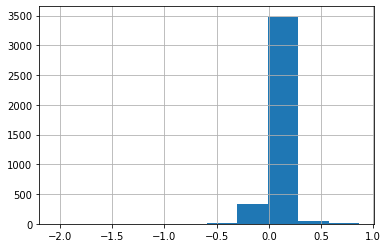

In [20]:
word_attribution_unique_df["attribution"].hist()

In [21]:
word_attribution_unique_df[word_attribution_unique_df["attribution"] > 0].min(),word_attribution_unique_df[word_attribution_unique_df["attribution"] > 0].max(),word_attribution_unique_df[word_attribution_unique_df["attribution"] > 0].mean(),word_attribution_unique_df[word_attribution_unique_df["attribution"] > 0].std()

(unique_words              ##10
 attribution        1.79045e-09
 abs_attribution    1.79045e-09
 No_occurences                1
 dtype: object,
 unique_words             zu
 attribution        0.864756
 abs_attribution    0.864756
 No_occurences          1216
 dtype: object,
 attribution        0.031467
 abs_attribution    0.032644
 No_occurences      7.034954
 dtype: float64,
 attribution         0.082794
 abs_attribution     0.083067
 No_occurences      37.072227
 dtype: float64)

In [22]:
word_attribution_unique_df[word_attribution_unique_df["attribution"] < 0].min(),word_attribution_unique_df[word_attribution_unique_df["attribution"] < 0].max(),word_attribution_unique_df[word_attribution_unique_df["attribution"] < 0].mean(),word_attribution_unique_df[word_attribution_unique_df["attribution"] < 0].std()

(unique_words                 !
 attribution           -2.05244
 abs_attribution    2.17037e-09
 No_occurences                1
 dtype: object,
 unique_words                 |
 attribution       -6.06497e-10
 abs_attribution        2.05244
 No_occurences              356
 dtype: object,
 attribution       -0.014542
 abs_attribution    0.015326
 No_occurences      3.511029
 dtype: float64,
 attribution         0.075281
 abs_attribution     0.075525
 No_occurences      16.683663
 dtype: float64)

In [23]:
word_attribution_unique_df[word_attribution_unique_df["attribution"] > 0.5].sort_values(by=["attribution"])

,unique_words,attribution,abs_attribution,No_occurences
1444,corporate,0.500310,0.500310,1
3656,ugly,0.507389,0.507389,1
2102,hooker,0.508178,0.508178,1
3800,wife,0.518999,0.518999,1
424,##mbo,0.529660,0.529660,3
1572,dignity,0.548697,0.548697,1
3808,wired,0.603071,0.603071,1
1814,feminist,0.624195,0.624195,10
1813,feminism,0.625263,0.625263,12
3511,teens,0.625902,0.625902,1


In [24]:
word_attribution_unique_df[word_attribution_unique_df["attribution"] < -0.3].sort_values(by=["attribution"])

,unique_words,attribution,abs_attribution,No_occurences
1013,atrocities,-2.052435,2.052435,1
1937,genuine,-1.735325,1.735325,1
1595,divorce,-0.697110,0.697110,1
154,##cott,-0.513327,0.513327,1
1201,bully,-0.505017,0.505017,2
566,##ri,-0.410231,0.410231,3
2190,interactions,-0.398776,0.398776,1
2739,overseas,-0.369200,0.369200,1
1581,disciplined,-0.358573,0.358573,1
1516,dc,-0.344440,0.344440,1


In [25]:
word_attribution_unique_df.sort_values(by=["attribution"],ascending=True)

,unique_words,attribution,abs_attribution,No_occurences
1013,atrocities,-2.052435,2.052435,1
1937,genuine,-1.735325,1.735325,1
1595,divorce,-0.697110,0.697110,1
154,##cott,-0.513327,0.513327,1
1201,bully,-0.505017,0.505017,2
...,...,...,...,...
3511,teens,0.625902,0.625902,1
267,##heart,0.694317,0.694317,1
3289,skulls,0.746687,0.746687,1
2071,hideous,0.853053,0.853053,1


In [26]:
word_attribution_unique_df.head(10)

,unique_words,attribution,abs_attribution,No_occurences
0,!,-1.853414e-03,9.658228e-03,143
1,##0,-1.012122e-03,1.687839e-03,17
2,##00,-2.195727e-02,2.195727e-02,2
3,##1,-3.101801e-02,3.159634e-02,21
4,##10,2.549642e-02,2.549815e-02,2
5,##11,-2.598034e-02,4.790739e-02,3
6,##13,1.633083e-02,1.633083e-02,2
7,##14,1.662007e-03,1.662007e-03,2
8,##15,4.889630e-03,7.458880e-03,27
9,##16,-4.721996e-08,4.721996e-08,1


In [27]:
word_attribution_unique_df.tail(10)

,unique_words,attribution,abs_attribution,No_occurences
3868,yourselves,-3.986501e-02,3.986501e-02,1
3869,youth,8.669071e-07,8.669071e-07,1
3870,yu,-1.148285e-05,1.207460e-05,8
3871,z,-4.687847e-03,5.774379e-03,19
3872,za,-2.287483e-06,2.287483e-06,4
3873,zero,-5.170837e-07,9.701612e-07,2
3874,zoe,-3.177177e-06,3.177177e-06,1
3875,zone,1.481000e-01,1.481000e-01,1
3876,zu,1.553298e-06,1.553298e-06,1
3877,|,-4.185723e-03,4.185723e-03,1


In [28]:
word_attribution_unique_df.to_csv("attribution_Scores/Fine-tuned_BERT/BERT_FT_on_Twitter_racism_1000_data_attribution_scores_grped_by_word.csv", index=False)

In [29]:
word_attribution_unique_df.corr()

,attribution,abs_attribution,No_occurences
attribution,1.000000,0.137427,0.006992
abs_attribution,0.137427,1.000000,-0.002028
No_occurences,0.006992,-0.002028,1.000000


## attribution scores of the linguistic features in normal text

In [30]:
def normalize(x):
    amin, amax = min(x), max(x)
    for i, val in enumerate(x):
         x[i] = (val-amin) / (amax-amin)
    return x        

In [31]:
def importance_score_of_ADJ_in_features (features):
    Twitter_rac_adj = features[features["pos"]=="ADJ"]
    adj_text = Twitter_rac_adj["text"].values
    attribution_adj = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in adj_text]
    attribution_adj = normalize(attribution_adj)
    adj_attribution = {}
    adj_attribution["adj"] = adj_text
    adj_attribution["adj_attribution"] = attribution_adj
    adj_attribution_df = pd.DataFrame.from_dict(adj_attribution)
    return adj_attribution_df

In [32]:
def importance_score_of_PRON_in_features (features):
    Twitter_rac_pron = features[features["pos"]=="PRON"]
    pron_text = Twitter_rac_pron["text"].values
    attribution_pron = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in pron_text]
    attribution_pron = normalize(attribution_pron)
    pron_attribution = {}
    pron_attribution["pron"] = pron_text
    pron_attribution["pron_attribution"] = attribution_pron
    pron_attribution_df = pd.DataFrame.from_dict(pron_attribution)
    return pron_attribution_df

In [33]:
def importance_score_of_DET_in_features (features):
    Twitter_rac_det = features[features["pos"]=="DET"]
    det_text = Twitter_rac_det["text"].values
    attribution_det = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in det_text]
    attribution_det = normalize(attribution_det)
    det_attribution = {}
    det_attribution["det"] = det_text
    det_attribution["det_attribution"] = attribution_det
    det_attribution_df = pd.DataFrame.from_dict(det_attribution)
    return det_attribution_df

In [34]:
def importance_score_of_ADV_in_features (features):
    Twitter_rac_adv = features[features["pos"]=="ADV"]
    adv_text = Twitter_rac_adv["text"].values
    attribution_adv = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in adv_text]
    attribution_adv = normalize(attribution_adv)
    adv_attribution = {}
    adv_attribution["adv"] = adv_text
    adv_attribution["adv_attribution"] = attribution_adv
    adv_attribution_df = pd.DataFrame.from_dict(adv_attribution)
    return adv_attribution_df

In [35]:
def importance_score_of_NOUN_in_features (features):
    Twitter_rac_noun = features[features["pos"]=="NOUN"]
    noun_text = Twitter_rac_noun["text"].values
    attribution_noun = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in noun_text]
    attribution_noun = normalize(attribution_noun)
    noun_attribution = {}
    noun_attribution["noun"] = noun_text
    noun_attribution["noun_attribution"] = attribution_noun
    noun_attribution_df = pd.DataFrame.from_dict(noun_attribution)
    return noun_attribution_df

In [36]:
def importance_score_of_VERB_in_features (features):
    Twitter_rac_verb = features[features["pos"]=="VERB"]
    verb_text = Twitter_rac_verb["text"].values
    attribution_verb = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in verb_text]
    attribution_verb = normalize(attribution_verb)
    verb_attribution = {}
    verb_attribution["verb"] = verb_text
    verb_attribution["verb_attribution"] = attribution_verb
    verb_attribution_df = pd.DataFrame.from_dict(verb_attribution)
    return verb_attribution_df

In [37]:
def importance_score_of_PUNCT_in_features (features):
    Twitter_rac_punc = features[features["pos"]=="PUNCT"]
    punc_text = Twitter_rac_punc["text"].values
    attribution_punc = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in punc_text]
    attribution_punc = normalize(attribution_punc)
    punc_attribution = {}
    punc_attribution["punc"] = punc_text
    punc_attribution["punc_attribution"] = attribution_punc
    punc_attribution_df = pd.DataFrame.from_dict(punc_attribution)
    return punc_attribution_df

In [38]:
def importance_score_of_PROPN_in_features (features):
    Twitter_rac_punc = features[features["pos"]=="PROPN"]
    punc_text = Twitter_rac_punc["text"].values
    attribution_punc = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in punc_text]
    attribution_punc = normalize(attribution_punc)
    punc_attribution = {}
    punc_attribution["propn"] = punc_text
    punc_attribution["propn_attribution"] = attribution_punc
    punc_attribution_df = pd.DataFrame.from_dict(punc_attribution)
    return punc_attribution_df

In [39]:
def importance_score_of_AUX_in_features (features):
    Twitter_rac_punc = features[features["pos"]=="AUX"]
    punc_text = Twitter_rac_punc["text"].values
    attribution_punc = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in punc_text]
    attribution_punc = normalize(attribution_punc)
    punc_attribution = {}
    punc_attribution["aux"] = punc_text
    punc_attribution["aux_attribution"] = attribution_punc
    punc_attribution_df = pd.DataFrame.from_dict(punc_attribution)
    return punc_attribution_df

In [40]:
def importance_score_of_ADP_in_features (features):
    Twitter_rac_punc = features[features["pos"]=="ADP"]
    punc_text = Twitter_rac_punc["text"].values
    attribution_punc = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in punc_text]
    attribution_punc = normalize(attribution_punc)
    punc_attribution = {}
    punc_attribution["adp"] = punc_text
    punc_attribution["adp_attribution"] = attribution_punc
    punc_attribution_df = pd.DataFrame.from_dict(punc_attribution)
    return punc_attribution_df

## attribution scores of POS in correct predicted docs

In [41]:
adj_attribution_df_correct_txt = importance_score_of_ADJ_in_features(data_docs_features_df)
pron_attribution_df_correct_txt = importance_score_of_PRON_in_features(data_docs_features_df)
noun_attribution_df_correct_txt = importance_score_of_NOUN_in_features(data_docs_features_df)
det_attribution_df_correct_txt = importance_score_of_DET_in_features(data_docs_features_df)
verb_attribution_df_correct_txt = importance_score_of_VERB_in_features(data_docs_features_df)
punc_attribution_df_correct_txt = importance_score_of_PUNCT_in_features(data_docs_features_df)
adv_attribution_df_correct_txt = importance_score_of_ADV_in_features(data_docs_features_df)
aaux_attribution_df_correct_txt = importance_score_of_AUX_in_features(data_docs_features_df)
propn_attribution_df_correct_txt = importance_score_of_PROPN_in_features(data_docs_features_df)
adp_attribution_df_correct_txt = importance_score_of_ADP_in_features(data_docs_features_df)

In [49]:
adj_attribution_df_correct_txt.to_csv("attribution_Scores/Fine-tuned_BERT/twitter_sex_adj_tags_importance_scores_df.csv",index=False)
pron_attribution_df_correct_txt.to_csv("attribution_Scores/Fine-tuned_BERT/twitter_sex_pron_tags_importance_scores_df.csv",index=False)
noun_attribution_df_correct_txt.to_csv("attribution_Scores/Fine-tuned_BERT/twitter_sex_noun_tags_importance_scores_df.csv",index=False)
det_attribution_df_correct_txt.to_csv("attribution_Scores/Fine-tuned_BERT/twitter_sex_det_tags_importance_scores_df.csv",index=False)
verb_attribution_df_correct_txt.to_csv("attribution_Scores/Fine-tuned_BERT/twitter_sex_verb_tags_importance_scores_df.csv",index=False)
punc_attribution_df_correct_txt.to_csv("attribution_Scores/Fine-tuned_BERT/twitter_sex_punc_tags_importance_scores_df.csv",index=False)
adv_attribution_df_correct_txt.to_csv("attribution_Scores/Fine-tuned_BERT/twitter_sex_adv_tags_importance_scores_df.csv",index=False)
aaux_attribution_df_correct_txt.to_csv("attribution_Scores/Fine-tuned_BERT/twitter_sex_aux_tags_importance_scores_df.csv",index=False)
propn_attribution_df_correct_txt.to_csv("attribution_Scores/Fine-tuned_BERT/twitter_sex_propn_tags_importance_scores_df.csv",index=False)
adp_attribution_df_correct_txt.to_csv("attribution_Scores/Fine-tuned_BERT/twitter_sex_adp_tags_importance_scores_df.csv",index=False)

In [54]:
det_attribution_df_correct_txt.det.unique(), len(det_attribution_df_correct_txt.det.unique())

(array(['the', 'that', 'their', 'this', 'his', 'aga', 'a', 'an', 'those',
        'my', 'all', 'these', 'your', 'no', 'which', 'some', 'every',
        'such', 'any', 'its', 'whatever', 'another', 'her', 'what', 'our',
        'fuck', 'both', 'whose', 'mc', 'x', 'twi', 'half', 'u', 'each',
        'm', 'yours', 'n', 'either', 'kurdistan.the', 'tbh', 'thug4u',
        'lovethe', 'mine', 'quite'], dtype=object),
 44)

In [55]:
pron_attribution_df_correct_txt.pron.unique(), len(pron_attribution_df_correct_txt.pron.unique())

(array(['i', 'what', 'he', 'who', 'you', 'it', 'they', 'me', 'we', 'them',
        'she', 'us', 'himself', 'her', 'u', 'itself', 'there',
        'themselves', 'someone', 'everything', 'him', 'anybody', 'anyone',
        'yourself', 'everyone', 'something', 'myself', 'yourselves',
        'anything', 'nothing', 'f', 'ya', 'nobody', 'ourselves', 'onc',
        'theirs', 'mine', 'wadhwa2015', 'everybody', 'one', 'zp71sq', 'mb',
        'yours', 'em', 'somebody', 'whoever', 'kn', 'ob', 's', 't_ftw',
        'you.you', 'whom', 'herself', 'hh', 'urself', 'wr', 'nw', 'qj'],
       dtype=object),
 58)

In [51]:
punc_attribution_df_correct_txt.punc.unique(), len(punc_attribution_df_correct_txt.punc.unique())

(array([':', '...', '.', ')', ',', '!', '`', '?', "''", ';', 'turner99',
        '..', '(', '*', '=', '-', '.twitter', 'flint93', '.i', 'a99pz',
        '//', '.ok', '^.^', '/', 'a9nw4ztr', 'iq8e2se', 'lies.no',
        'falasteen', '.sns', '0', 'nui12', '.vid', '[', ']', '.its',
        'cook.mkr', 'xb3epww', '/-', '.can', 'omg', '.mkr', 'capacity.so',
        'v1s0', '.you', '/popehat', '.call', 'x0cb60w', 'v0k', '.pretty',
        '--', '-kaylies', '.not', 'preston.mkr', '-my', 't39md', '-and-',
        'malin85', '/baph', '~', 'zeebie05', '.the', 'meth', '.really',
        '+', 'd6pe0', 'd28kc', 'zt7p0oh', '-ig', 'z_siv', 'falcon77',
        '.robs', '.in', 'j8ay5'], dtype=object),
 73)

In [53]:
import string

string.punctuation
len([i for i in punc_attribution_df_correct_txt.punc.unique() if i not in string.punctuation])

56

In [52]:
aaux_attribution_df_correct_txt.aux.unique(), len(aaux_attribution_df_correct_txt.aux.unique())

(array(['is', 'were', 'are', 'do', 'being', 'am', 'be', 'was', 'has',
        'have', 'did', 'get', 'does', 'been', 'had'], dtype=object),
 15)

In [45]:
print("ADJ",np.mean(adj_attribution_df_correct_txt["adj_attribution"]))
print("PRON", np.mean(pron_attribution_df_correct_txt["pron_attribution"]))
print("NOUN",np.mean(noun_attribution_df_correct_txt["noun_attribution"]))
print("DET",np.mean(det_attribution_df_correct_txt["det_attribution"]))
print("VERB",np.mean(verb_attribution_df_correct_txt["verb_attribution"]))
print("PUNC",np.mean(punc_attribution_df_correct_txt["punc_attribution"]))
print("ADV",np.mean( adv_attribution_df_correct_txt["adv_attribution"]))
print("PROPN",np.mean(propn_attribution_df_correct_txt["propn_attribution"]))
print("AUX",np.mean(aaux_attribution_df_correct_txt["aux_attribution"]))
print("ADP",np.mean(adp_attribution_df_correct_txt["adp_attribution"]))

ADJ 0.01413653824816135
PRON 0.2065667928797599
NOUN 0.01442144575547459
DET 0.12100458077241481
VERB 0.020961577451156226
PUNC 0.404415316944238
ADV 0.03596785209988526
PROPN 0.01857126954619886
AUX 0.45619644092356954
ADP 0.04215060118498179


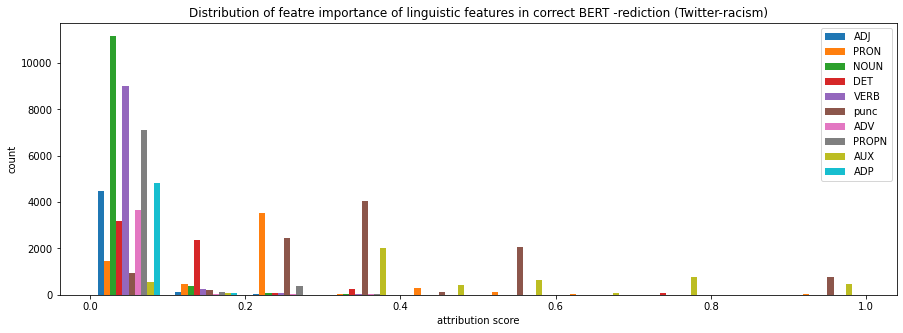

In [46]:
plt.subplots(figsize=(15, 5))
plt.hist([adj_attribution_df_correct_txt["adj_attribution"],
          pron_attribution_df_correct_txt["pron_attribution"],
          noun_attribution_df_correct_txt["noun_attribution"],
          det_attribution_df_correct_txt["det_attribution"],
         verb_attribution_df_correct_txt["verb_attribution"],
         punc_attribution_df_correct_txt["punc_attribution"],
         adv_attribution_df_correct_txt["adv_attribution"],
         propn_attribution_df_correct_txt["propn_attribution"],
         aaux_attribution_df_correct_txt["aux_attribution"],
         adp_attribution_df_correct_txt["adp_attribution"]],
         label=["ADJ","PRON","NOUN","DET","VERB","punc","ADV", "PROPN", "AUX", "ADP"], stacked=False)
plt.xlabel("attribution score")
plt.ylabel("count")
plt.title("Distribution of featre importance of linguistic features in correct BERT -rediction (Twitter-racism)")
plt.legend()

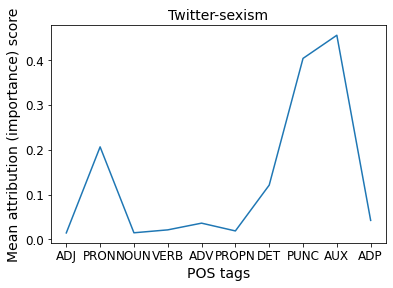

In [47]:
plt.plot(["ADJ","PRON","NOUN","VERB","ADV", "PROPN","DET","PUNC", "AUX", "ADP"],
        [adj_attribution_df_correct_txt["adj_attribution"].mean(),
          pron_attribution_df_correct_txt["pron_attribution"].mean(),
          noun_attribution_df_correct_txt["noun_attribution"].mean(),
         verb_attribution_df_correct_txt["verb_attribution"].mean(),
         adv_attribution_df_correct_txt["adv_attribution"].mean(),         
         propn_attribution_df_correct_txt["propn_attribution"].mean(),
         det_attribution_df_correct_txt["det_attribution"].mean(),
         punc_attribution_df_correct_txt["punc_attribution"].mean(),
         aaux_attribution_df_correct_txt["aux_attribution"].mean(),
         adp_attribution_df_correct_txt["adp_attribution"].mean()])
plt.title("Twitter-sexism", fontsize=14)
plt.ylabel("Mean attribution (importance) score", fontsize=14)
plt.xlabel("POS tags",fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("Twitter-sexism-pos-tags.eps",format='eps',bbox_inches='tight')

In [48]:
pos_tags_importance_scores_df = pd.DataFrame.from_dict({"POS_tag":["ADJ","PRON","NOUN","VERB","ADV", "PROPN","DET","PUNC", "AUX", "ADP"],
                                                        "mean_importance_score":[adj_attribution_df_correct_txt["adj_attribution"].mean(),
                                                          pron_attribution_df_correct_txt["pron_attribution"].mean(),
                                                          noun_attribution_df_correct_txt["noun_attribution"].mean(),
                                                         verb_attribution_df_correct_txt["verb_attribution"].mean(),
                                                         adv_attribution_df_correct_txt["adv_attribution"].mean(),         
                                                         propn_attribution_df_correct_txt["propn_attribution"].mean(),
                                                         det_attribution_df_correct_txt["det_attribution"].mean(),
                                                         punc_attribution_df_correct_txt["punc_attribution"].mean(),
                                                         aaux_attribution_df_correct_txt["aux_attribution"].mean(),
                                                         adp_attribution_df_correct_txt["adp_attribution"].mean()]})
pos_tags_importance_scores_df.to_csv("attribution_Scores/Fine-tuned_BERT/twitter_sexism_pos_tags_importance_scores_df.csv")

In [72]:
adj_attribution_df_correct_txt[adj_attribution_df_correct_txt["adj_attribution"]> 0.2].groupby("adj").adj_attribution.mean()

adj
muslim         0.285589
palestinian    0.361015
quran          0.242079
religious      0.342664
terrorist      0.211479
western        0.372930
Name: adj_attribution, dtype: float64

In [75]:
adv_attribution_df_correct_txt[adv_attribution_df_correct_txt["adv_attribution"]>0.01].groupby("adv").adv_attribution.mean()

adv
again          0.030999
ago            0.010031
along          0.018904
at             0.012347
backwards      0.031443
before         0.014922
bloody         0.036826
closely        0.014875
everywhere     0.095768
exactly        0.031976
globally       0.037542
long           0.011410
mainly         0.013767
no             0.010329
once           0.058560
politically    0.035842
purposely      0.078708
rather         0.017261
real           0.011328
seldom         0.014222
super          0.058372
third          0.025319
through        0.015695
whore          0.059234
why            0.011153
yet            0.012263
Name: adv_attribution, dtype: float64

In [76]:
noun_attribution_df_wrong_txt[noun_attribution_df_wrong_txt["noun_attribution"]> 0.2].groupby("noun").noun_attribution.mean()

noun
ancestors       0.465710
audiences       0.739988
christianity    0.214510
compulsion      0.218618
islam           0.329697
mosque          0.248595
muslims         0.257012
phd             1.290690
prophet         0.320521
quran           0.242079
slavery         0.304165
terrorist       0.211479
Name: noun_attribution, dtype: float64

In [82]:
noun_attribution_df_correct_txt[noun_attribution_df_correct_txt["noun_attribution"]> 0.5].groupby("noun").noun_attribution.mean()

noun
answer     0.603773
display    0.738758
islam      0.655102
muslim     0.526257
Name: noun_attribution, dtype: float64

## attribution scores of important words

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [40]:
train_df = pd.read_csv("../../../Data/Twitter_racism/Twitter_rac_data_train.csv").dropna()
test_df = pd.read_csv("../../../Data/Twitter_racism/Twitter_rac_data_test.csv").dropna()

vectorizer_train = TfidfVectorizer()
X = vectorizer_train.fit_transform(train_df["Text_clean"].values)
y = train_df["oh_label"].values

clf = MultinomialNB()
clf.fit(X, y)
neg_class_prob_sorted = clf.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = clf.feature_log_prob_[1, :].argsort()
print(np.take(vectorizer_train.get_feature_names(), neg_class_prob_sorted[-10:]))
print(np.take(vectorizer_train.get_feature_names(), pos_class_prob_sorted[-10:]))

['get' 'people' 'would' 'your' 'andre' 'like' 'kat' 'they' 'you' 'mkr']
['prophet' 'jews' 'religion' 'blumenthal' 'they' 'mohammed' 'muslim' 'you'
 'muslims' 'islam']


In [47]:
word_attribution_unique_df[(word_attribution_unique_df["unique_words"] == "prophet")|
                          (word_attribution_unique_df["unique_words"] == "jew") | 
                          (word_attribution_unique_df["unique_words"] == "religion") |
                          (word_attribution_unique_df["unique_words"] == "blumenthal") |
                          (word_attribution_unique_df["unique_words"] == "mohammed") |
                          (word_attribution_unique_df["unique_words"] == "mohammed") |
                          (word_attribution_unique_df["unique_words"] == "muslim") |
                          (word_attribution_unique_df["unique_words"] == "muslims") |
                          (word_attribution_unique_df["unique_words"] == "islam")]

,unique_words,attribution,abs_attribution,No_occurences
2151,islam,0.621503,0.655102,91
2179,jew,0.498244,0.498244,17
2454,muslim,0.515682,0.526257,67
2692,prophet,0.267429,0.267429,17
2767,religion,0.293257,0.319499,14


In [46]:
word_attribution_unique_df[(word_attribution_unique_df["unique_words"] == "get")|
                          (word_attribution_unique_df["unique_words"] == "people") | 
                          (word_attribution_unique_df["unique_words"] == "andre") |
                          (word_attribution_unique_df["unique_words"] == "like") |
                          (word_attribution_unique_df["unique_words"] == "kat") |
                          (word_attribution_unique_df["unique_words"] == "mkr") |
                          (word_attribution_unique_df["unique_words"] == "would") |
                          (word_attribution_unique_df["unique_words"] == "your") |
                          (word_attribution_unique_df["unique_words"] == "you")]

,unique_words,attribution,abs_attribution,No_occurences
1972,get,0.016739,0.022413,64
2219,kat,-0.000126,0.000126,55
2285,like,0.018238,0.019148,65
3318,would,-0.003635,0.010125,31
3345,you,0.037689,0.044160,3


In [91]:
data_correct_prediction_features_df.columns

Index(['text', 'lemma', 'pos', 'tag', 'dep', 'shape', 'is_alpha', 'is_stop'], dtype='object')

In [93]:
data_correct_prediction_features_df[(data_correct_prediction_features_df["text"] == "get")|
                          (data_correct_prediction_features_df["text"] == "people") | 
                          (data_correct_prediction_features_df["text"] == "andre") |
                          (data_correct_prediction_features_df["text"] == "like") |
                          (data_correct_prediction_features_df["text"] == "kat") |
                          (data_correct_prediction_features_df["text"] == "mkr") |
                          (data_correct_prediction_features_df["text"] == "would") |
                          (data_correct_prediction_features_df["text"] == "your") |
                          (data_correct_prediction_features_df["text"] == "you")]["pos"].unique()

array(['SCONJ', 'PRON', 'DET', 'AUX', 'PROPN', 'VERB', 'NOUN', 'INTJ',
       'ADJ', 'X'], dtype=object)

In [95]:
data_correct_prediction_features_df[(data_correct_prediction_features_df["text"] == "prophet")|
                          (data_correct_prediction_features_df["text"] == "jew") | 
                          (data_correct_prediction_features_df["text"] == "religion") |
                          (data_correct_prediction_features_df["text"] == "blumenthal") |
                          (data_correct_prediction_features_df["text"] == "mohammed") |
                          (data_correct_prediction_features_df["text"] == "mohammed") |
                          (data_correct_prediction_features_df["text"] == "muslim") |
                          (data_correct_prediction_features_df["text"] == "muslims") |
                          (data_correct_prediction_features_df["text"] == "islam")]["pos"].unique()

array(['PROPN', 'NOUN', 'ADJ', 'VERB'], dtype=object)

In [50]:
adj_attribution_df_correct_txt.columns

Index(['adj', 'adj_attribution'], dtype='object')

In [63]:
adj_attribution_df_correct_txt[
                          (adj_attribution_df_correct_txt["adj"] == "blumenthal") |
                          (adj_attribution_df_correct_txt["adj"] == "muslim") ].groupby("adj").adj_attribution.mean()

adj
blumenthal    0.000000
muslim        0.526257
Name: adj_attribution, dtype: float64

In [67]:
adj_attribution_df_wrong_txt[
                          (adj_attribution_df_wrong_txt["adj"] == "blumenthal") |
                          (adj_attribution_df_wrong_txt["adj"] == "muslim") ].groupby("adj").adj_attribution.mean()

adj
muslim    0.526257
Name: adj_attribution, dtype: float64

In [65]:
noun_attribution_df_correct_txt[(noun_attribution_df_correct_txt["noun"] == "prophet")|
                          (noun_attribution_df_correct_txt["noun"] == "jew") | 
                          (noun_attribution_df_correct_txt["noun"] == "religion") |
                          (noun_attribution_df_correct_txt["noun"] == "mohammed") |
                          (noun_attribution_df_correct_txt["noun"] == "muslims") |
                          (noun_attribution_df_correct_txt["noun"] == "islam")].groupby("noun").noun_attribution.mean()

noun
islam       0.655102
prophet     0.267429
religion    0.319499
Name: noun_attribution, dtype: float64

In [68]:
noun_attribution_df_wrong_txt[(noun_attribution_df_wrong_txt["noun"] == "prophet")|
                          (noun_attribution_df_wrong_txt["noun"] == "jew") | 
                          (noun_attribution_df_wrong_txt["noun"] == "religion") |
                          (noun_attribution_df_wrong_txt["noun"] == "mohammed") |
                          (noun_attribution_df_wrong_txt["noun"] == "muslims") |
                          (noun_attribution_df_wrong_txt["noun"] == "islam")].groupby("noun").noun_attribution.mean()

noun
islam       0.655102
muslims     0.000000
prophet     0.267429
religion    0.319499
Name: noun_attribution, dtype: float64